# Classificação de espécies de cogumelos

Importação de bibliotecas e dados necessários

In [545]:
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image
ALLOWLIST_FORMATS = (".bmp", ".gif", ".jpeg", ".jpg", ".png")

In [546]:
##Carregando as imagens do caminho 
dataset_directory = pathlib.Path("C:\\GitHub\\MushroomClassification\\Mushrooms\\")

image_count = len(list(dataset_directory.glob('*/*.jpg')))
print("Quantidade total de Imagens: " + str(image_count))

Quantidade total de Imagens: 6467


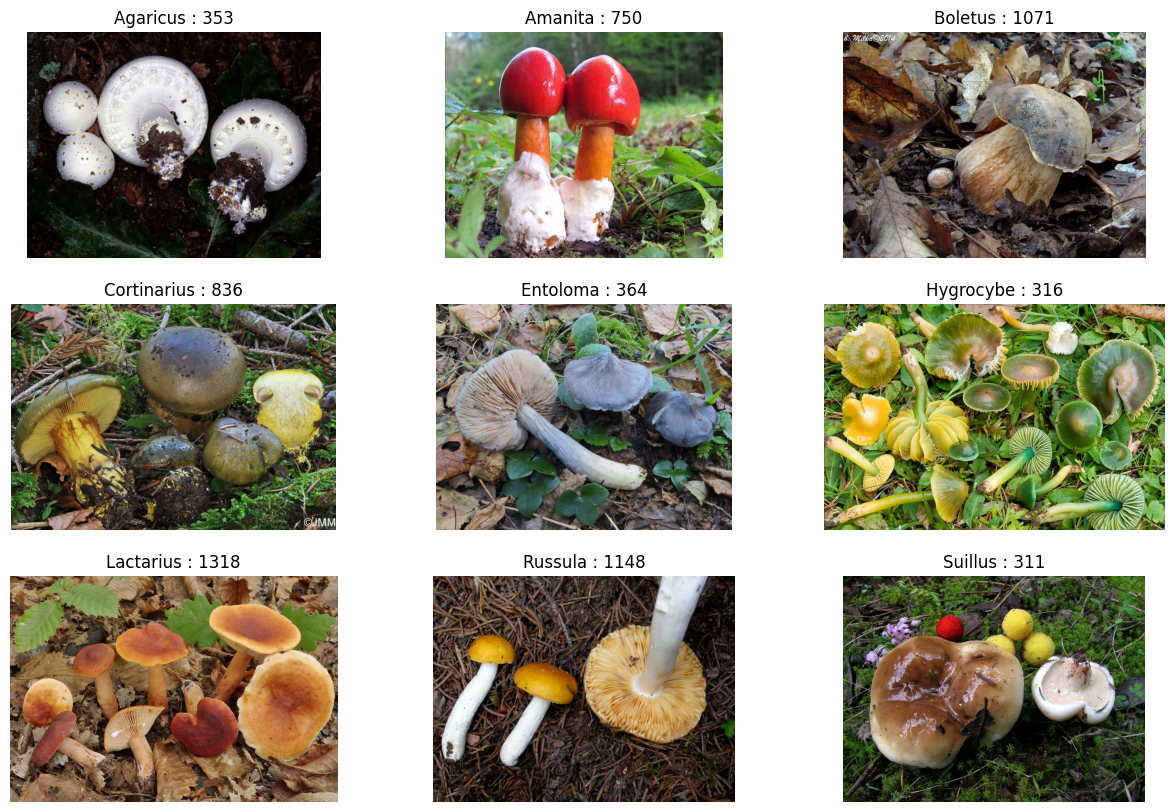

In [547]:
#Visualização de 1 imagens de cada classe no caminho do dataset com suas quantidades
especies = ['Agaricus','Amanita','Boletus','Cortinarius','Entoloma','Hygrocybe','Lactarius','Russula','Suillus']


i=0
plt.figure(figsize=(15, 10))
for Nameclasse in especies:
    Nome = Nameclasse+"/*"
    ds = list(dataset_directory.glob(Nome))
    userImage = Image.open(str(ds[0]))  
    
    ax = plt.subplot(3, 3, i + 1) 
    plt.imshow(userImage)       
    plt.title(Nameclasse + " : "+str(len(ds)))
    plt.axis("off")
    i=i+1

# Criando Data Set das imagens do caminho padrão

In [548]:
#Configuração da Imagens do Dataset
batch_size = 32
img_height = 224
img_width = 224

Treino

In [549]:
treino_img = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    labels="inferred",
    label_mode="int",
    validation_split=0.4,
    subset="training",
    seed=123,
    shuffle="True",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6467 files belonging to 9 classes.
Using 3881 files for training.


Validação

In [550]:
validacao_image = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,
    labels="inferred",
    label_mode="int",
    validation_split=0.5,
    subset="validation",
    seed=123,
    shuffle="True",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6467 files belonging to 9 classes.
Using 3233 files for validation.


### Configurando Parametros de performance do dataset

In [553]:
AUTOTUNE = tf.data.AUTOTUNE
treino_img = treino_img.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validacao_image = validacao_image.cache().prefetch(buffer_size=AUTOTUNE)

#Padronização dos Dados

In [555]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = treino_img.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Observe que os valores de pixel agora estão em `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9645766


#Dados

In [556]:
data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical",
                        input_shape=(img_height,
                                    img_width,
                                    3)),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ])

#Mostrar a imagem de cogumelos de diversos angulos para a classificação

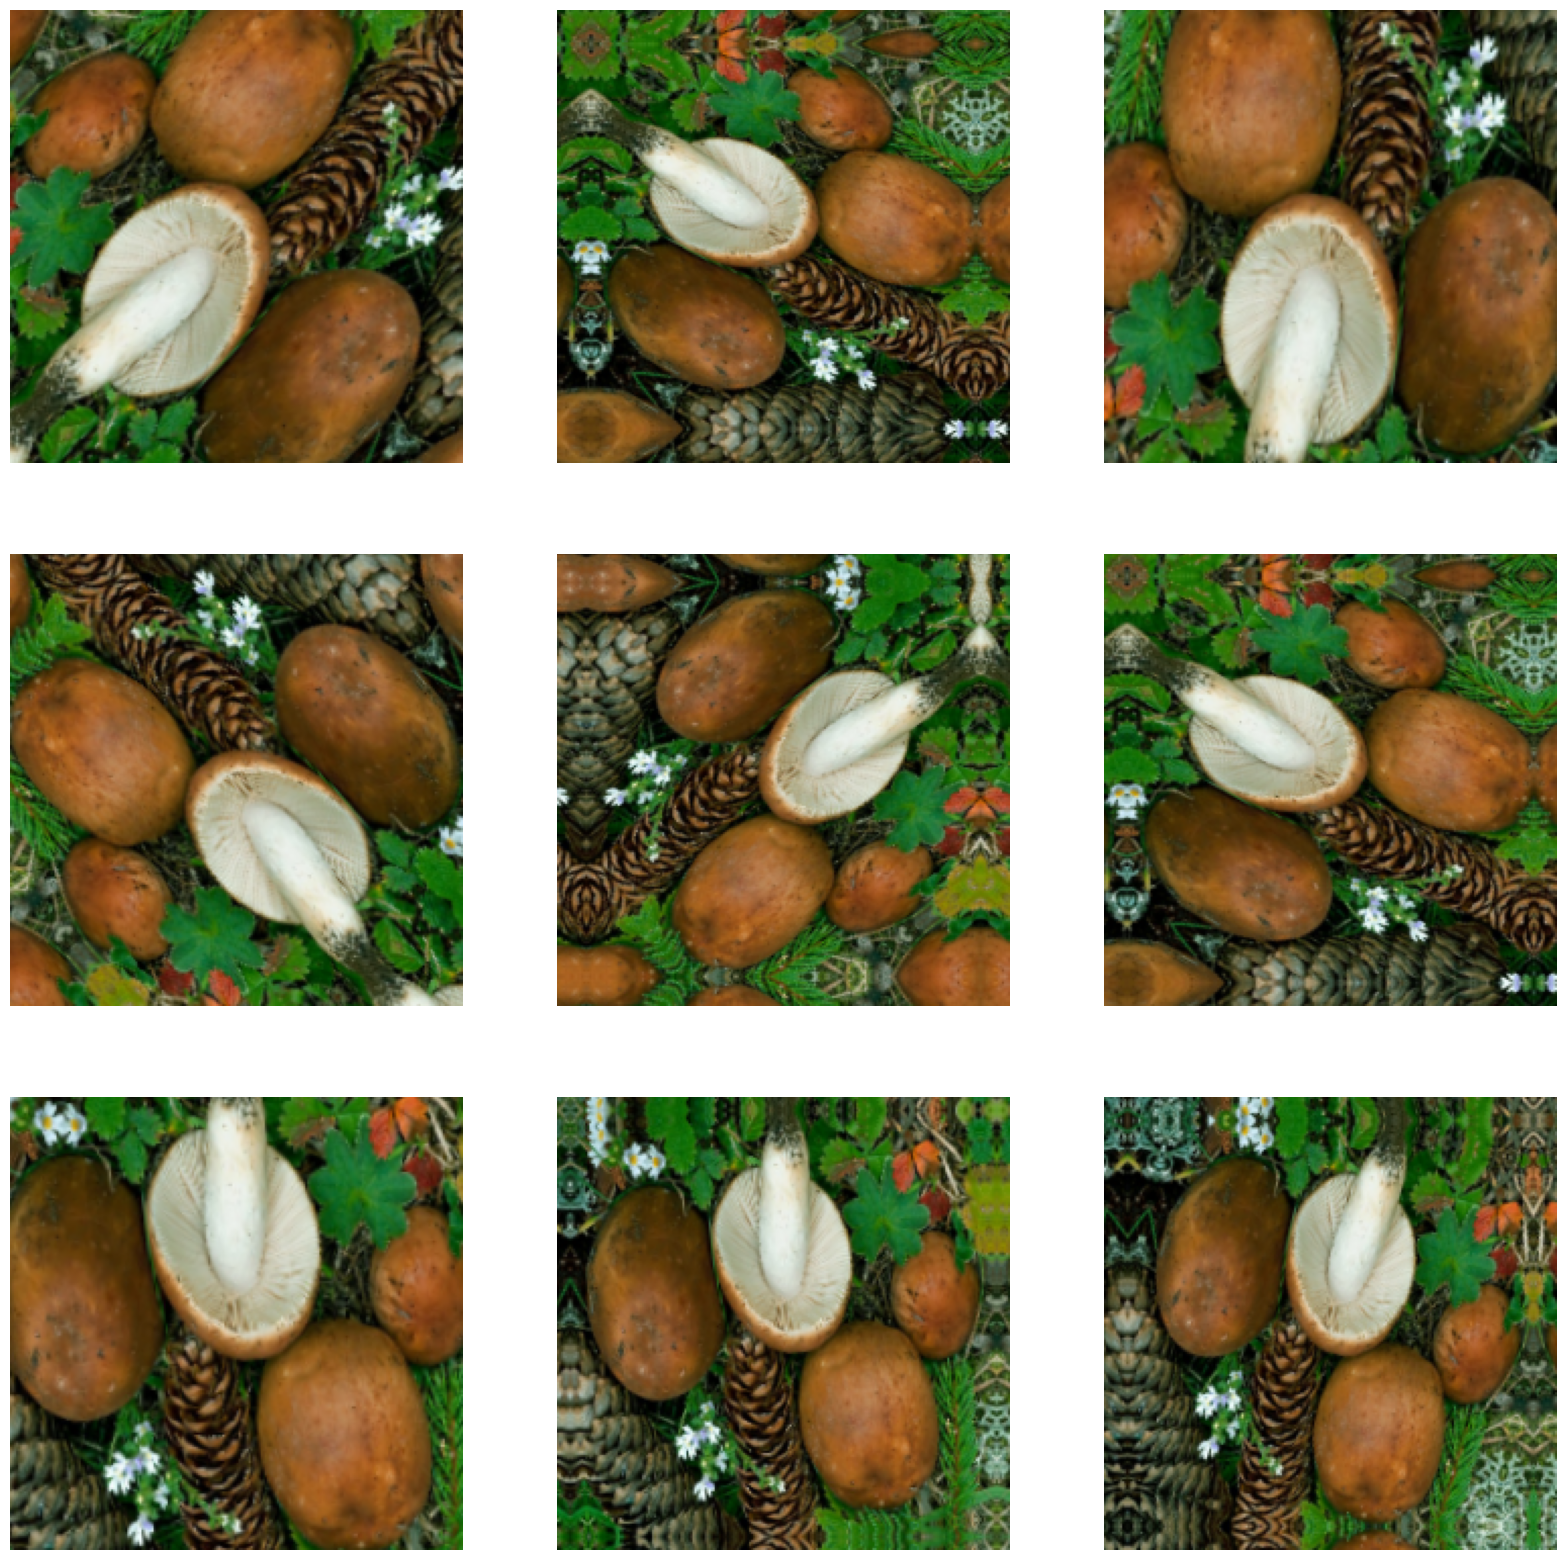

In [557]:
plt.figure(figsize=(20, 20))
for images, _ in treino_img.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Treinando o modelo

#Criando o modelo

In [559]:
num_classes = len(especies)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#Executando o Modelo

In [560]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Resumo

In [561]:
model.summary()

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_71 (Sequential)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_101 (Rescaling)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_108 (Conv2D)                  │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_108 (MaxPooling2D)     │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_109 (Conv2D)                  │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_109 (MaxPooling2D)     │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_110 (Conv2D)                  │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_110 (MaxPooling2D)     │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_36 (Flatten)                 │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,447,401 (24.59 MB)

 Trainable params: 6,447,401 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

Retorno

In [562]:
from collections.abc import Iterable
from wandb.integration.keras import WandbModelCheckpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("Model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch")
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=40, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              mode='max', cooldown=2, patience=2, min_lr=0)

Treinando o Modelo

In [563]:
epochs = 20
history = model.fit(treino_img, validation_data=validacao_image,
    epochs=epochs
    ,callbacks=[checkpoint, early, reduce_lr]
)

Epoch 1/20
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.1970 - loss: 2.0852
Epoch 1: val_accuracy improved from -inf to 0.26570, saving model to Model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 75s 571ms/step - accuracy: 0.1971 - loss: 2.0849 - val_accuracy: 0.2657 - val_loss: 1.9810 - learning_rate: 1.0000e-04
Epoch 2/20
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.2549 - loss: 1.9567
Epoch 2: val_accuracy improved from 0.26570 to 0.27621, saving model to Model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 60s 484ms/step - accuracy: 0.2549 - loss: 1.9566 - val_accuracy: 0.2762 - val_loss: 1.8975 - learning_rate: 1.0000e-04
Epoch 3/20
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.2803 - loss: 1.8639
Epoch 3: val_accuracy improved from 0.27621 to 0.31488, saving model to Model.keras
122/122 ━━━━━━━━━━━━━━━━━━━━ 59s 488ms/step - accuracy: 0.2804 - loss: 1.8640 - val_accuracy: 0.3149 - val_loss: 1.8491 - learning_rate: 1.0000e-04
Epoch 4/20
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 

#Resultados do treinamento

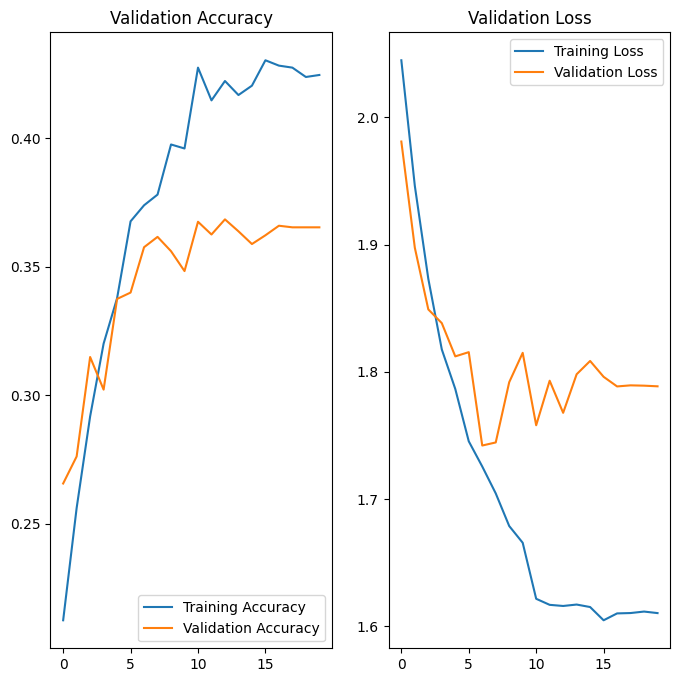

In [564]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.title('Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.title('Validation Loss')
plt.show()

#Prever em novos dados

In [ ]:
testing_directory = pathlib.Path("C:\\GitHub\\MushroomClassification\\TestingNovoDataSet")

testing_files = list(testing_directory.glob('*.jpg'))

for file in testing_files:
    image = tf.keras.preprocessing.image.load_img(file, target_size=(img_height, img_width))

    image_array = tf.keras.utils.img_to_array(image)
    image_array = tf.expand_dims(image_array, 0) # Create a batch

    predictions = model.predict(image_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This {} most likely belongs to {} with a {:.2f} percent confidence."
        .format(file, especies[np.argmax(score)], 100 * np.max(score))
    )